In [165]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

In [166]:
img_path = 'test_0.jpg'
img = Image.open(img_path).resize((224, 224))
img = np.array(img)
img = np.array(img).astype('float32')

In [167]:
def show_data(img, n=1, title=""):
    plt.figure(figsize=(10, 10))
    plt.imshow(image.array_to_img(img))
    plt.suptitle(title, fontsize = 20)

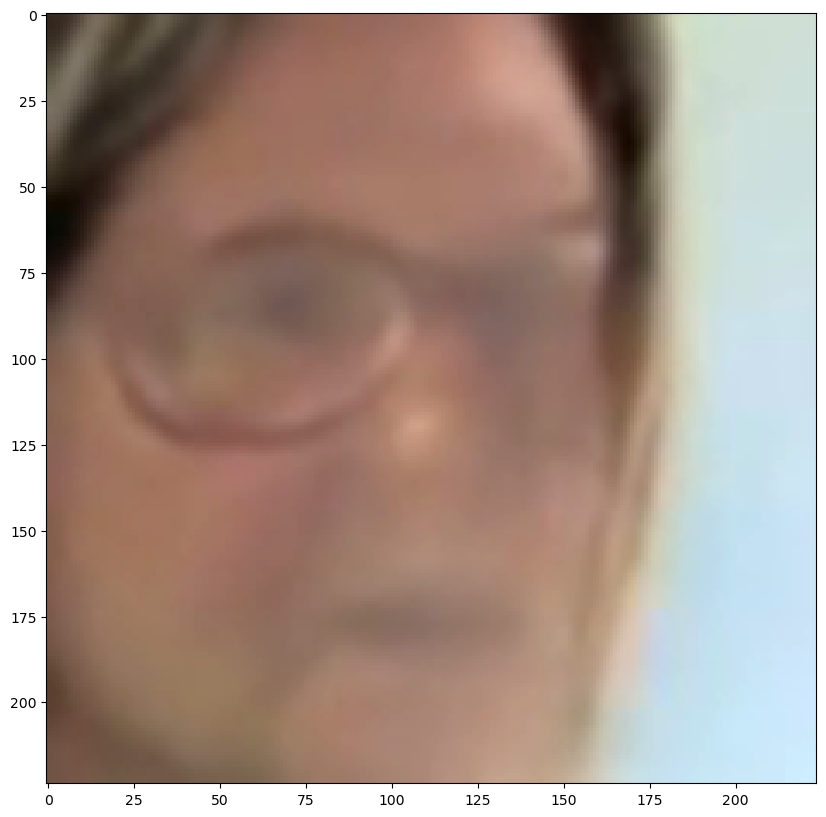

In [168]:
show_data(img)

In [169]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [170]:
image = Image.open(img_path).convert('RGB')
input_tensor = preprocess(image).unsqueeze(0).to('cuda')

In [171]:
from VisionKAN import create_model, train_one_epoch, evaluate
device = torch.device("cuda")

KAN = create_model(
    model_name='deit_tiny_patch16_224_KAN',
    pretrained=False,
    hdim_kan=192,
    num_classes=1,
    drop_rate=0.0,
    drop_path_rate=0.05,
    img_size=224,
    batch_size=32
)

# VisionLSTM model
vision_lstm = torch.hub.load("nx-ai/vision-lstm", "VisionLSTM", 
    dim=192,  
    depth=24,  
    patch_size=16,
    input_shape=(3, 224, 224),  
    output_shape=(1,),  
    drop_path_rate=0.05,  
    stride=None 
)

{'hdim_kan': 192, 'num_classes': 1, 'drop_rate': 0.0, 'drop_path_rate': 0.05, 'img_size': 224, 'batch_size': 32}


Using cache found in C:\Users\rajat/.cache\torch\hub\nx-ai_vision-lstm_main


In [172]:
# Custom Model combining ViT and VisionLSTM
class CombinedModel(nn.Module):
    def __init__(self, KAN, vision_lstm):
        super(CombinedModel, self).__init__()
        self.KAN = KAN
        self.vision_lstm = vision_lstm
        self.fc1 = nn.Linear(2, 512)
        self.fc2 = nn.Linear(512, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        KAN_output = self.KAN(x)
        lstm_output = self.vision_lstm(x)
        combined = torch.cat((KAN_output, lstm_output), dim=1)
        x = self.fc1(combined)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

model = CombinedModel(KAN, vision_lstm).to(device)

In [173]:
model.load_state_dict(torch.load("as_model_0.965.pt", map_location=torch.device('cuda')))
model.eval()

C:\Users\rajat\AppData\Local\Temp\ipykernel_1416\1432698651.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("as_model_0.965.pt", map_loc

CombinedModel(
  (KAN): VisionKAN(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): kanBlock(
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=False)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
      

In [174]:
# Predict
with torch.no_grad():
    output = model(input_tensor)
    prob = output.item()

# Threshold at 0.5
if prob < 0.5:
    print("Prediction: FAKE")
else:
    print("Prediction: REAL")

Prediction: FAKE
